# California housing dataset 
## Part I: Basic EDA and baseline model

### Goals:
- Exploratory data analysis (EDA)
- Training linear regression model predicting the median house value in a city block based on a single other feature
- Constructing an evaluation metric with visualization

In [1]:
from __future__ import print_function

import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
cali_housing_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
print(cali_housing_data.info())
cali_housing_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
longitude             17000 non-null float64
latitude              17000 non-null float64
housing_median_age    17000 non-null float64
total_rooms           17000 non-null float64
total_bedrooms        17000 non-null float64
population            17000 non-null float64
households            17000 non-null float64
median_income         17000 non-null float64
median_house_value    17000 non-null float64
dtypes: float64(9)
memory usage: 1.2 MB
None


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0  
3       515.0       226.0         3.1917             73400.0  
4       624.0       262.0         1.9250             65500.0

In [3]:
cali_housing_data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  17000.000000  17000.000000        17000.000000  17000.000000   
mean    -119.562108     35.625225           28.589353   2643.664412   
std        2.005166      2.137340           12.586937   2179.947071   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.790000     33.930000           18.000000   1462.000000   
50%     -118.490000     34.250000           29.000000   2127.000000   
75%     -118.000000     37.720000           37.000000   3151.250000   
max     -114.310000     41.950000           52.000000  37937.000000   

       total_bedrooms    population    households  median_income  \
count    17000.000000  17000.000000  17000.000000   17000.000000   
mean       539.410824   1429.573941    501.221941       3.883578   
std        421.499452   1147.852959    384.520841       1.908157   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    790.000000    282.000000       2.566375   
50%        434.000000   1167.000000    409.000000       3.544600   
75%        648.250000   1721.000000    605.250000       4.767000   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        17000.000000  
mean        207300.912353  
std         115983.764387  
min          14999.000000  
25%         119400.000000  
50%         180400.000000  
75%         265000.000000  
max         500001.000000

In [4]:
# check for NaNs in the dataset
check_nans = lambda cali_housing_data: cali_housing_data[cali_housing_data.isnull().any(axis=1)]
len(check_nans(cali_housing_data))

0

### Basic observations about the dataset after the first glance:
- 170000 features, 
- all floating-point numerical
- no NaNs

Data is at the city block level, `total_rooms` represents the total number of rooms in the block, `median_house_value` is a good label to predict

In [5]:
# Rescale median_house_value (target variable) to reasonable bounds
cali_housing_data["median_house_value"] /= 1000
# Randomize the data
cali_housing_data = cali_housing_data.reindex(
    np.random.permutation(cali_housing_data.index))
cali_housing_data.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
7654     -118.37     33.93                46.0       1130.0           201.0   
911      -117.08     32.68                19.0       3635.0          1078.0   
16626    -122.72     38.43                31.0       2020.0           476.0   
10624    -120.48     37.32                13.0       3641.0           897.0   
12057    -121.42     38.57                38.0       1878.0           338.0   

       population  households  median_income  median_house_value  
7654        503.0       196.0         4.4861               246.3  
911        3127.0      1098.0         1.3240               122.6  
16626      1408.0       437.0         2.5735               131.1  
10624      1737.0       788.0         2.1418               130.6  
12057       710.0       342.0         3.7731               161.4

## Exploratory data analysis
- correlation matrix (heatmap)
- scatter plots with distributions

<Figure size 576x576 with 0 Axes>

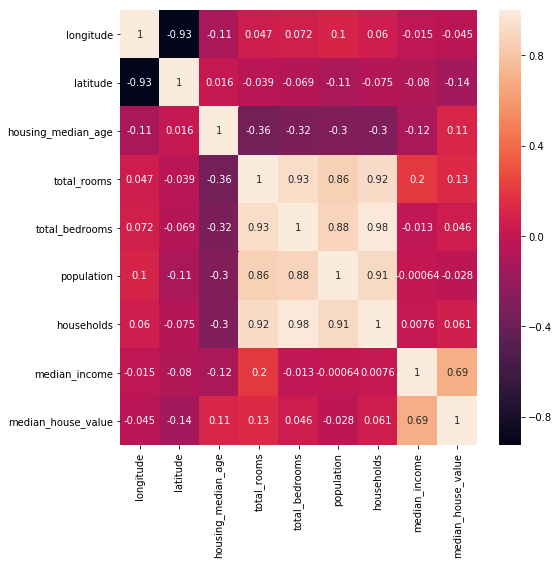

In [6]:
plt.figure(figsize=(8, 8))
corr = cali_housing_data.corr()
sns.heatmap(corr, annot=True)

Correlation matrix findings:
- long and lat are inversly correlated, as expected
- there's quite a strong positive correlation betw. total_rooms, total_bedrooms, population and households - might be worth investigating further
- another interesting correlation is betw. median_house_value and income - since i want to work with median_house_value as my target, i'd be useful to test its predictions based on income vs. any other feature

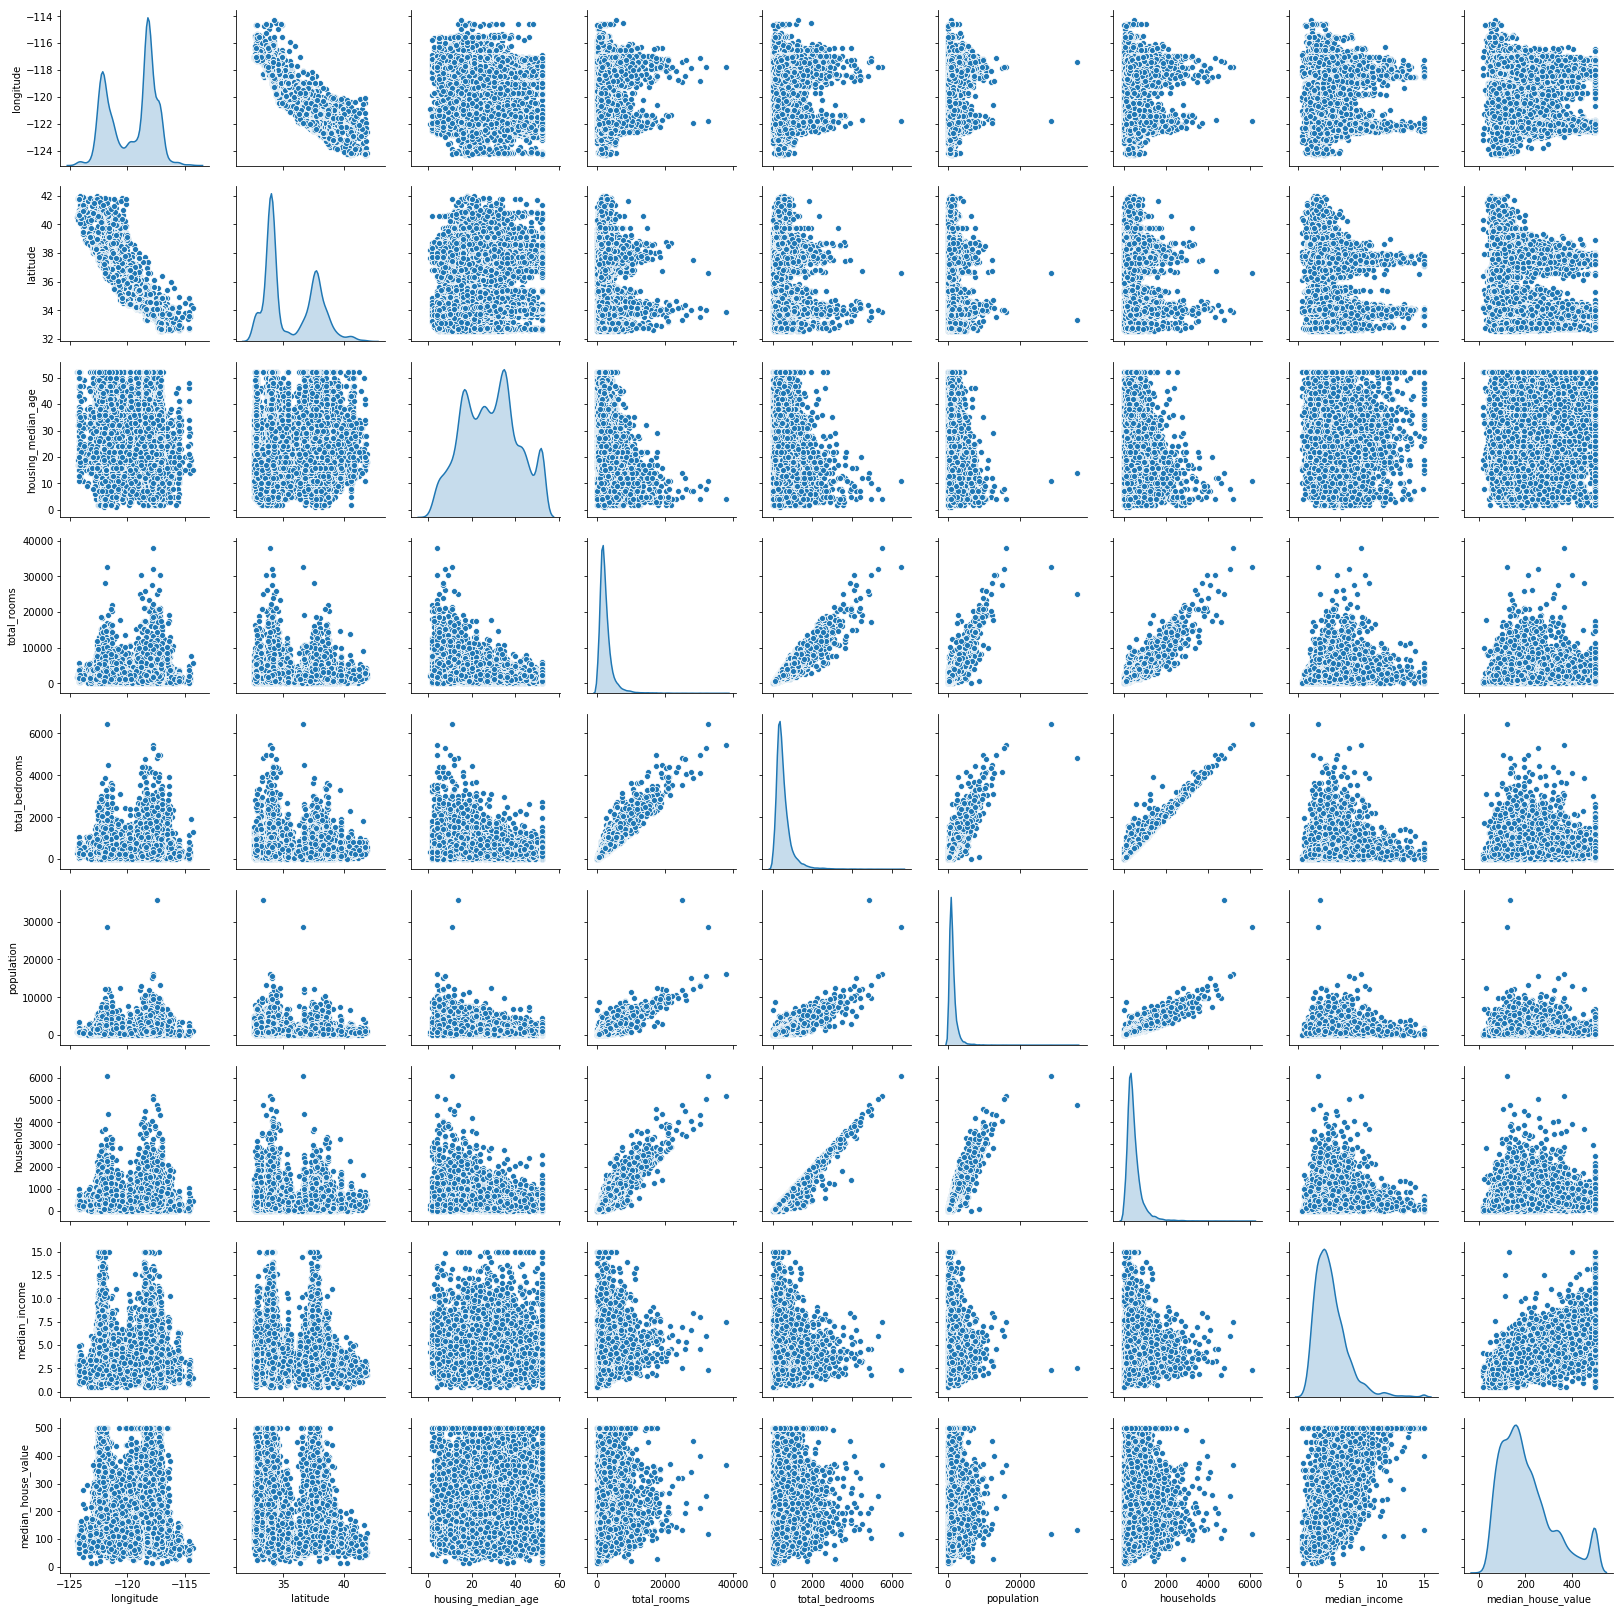

In [7]:
sns.pairplot(cali_housing_data, diag_kind="kde")

As expected, correlated features show +- linear dependence in the scatter plots, otherwise nothing interesting. Let's look at the distributions more closely:

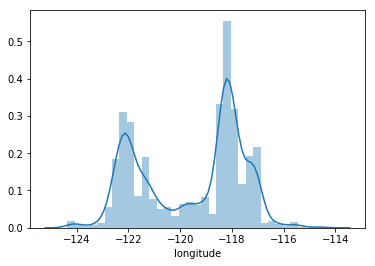

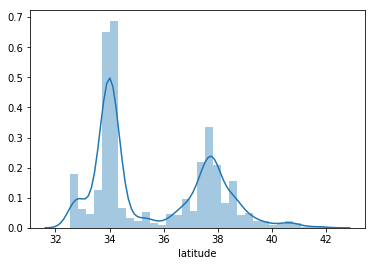

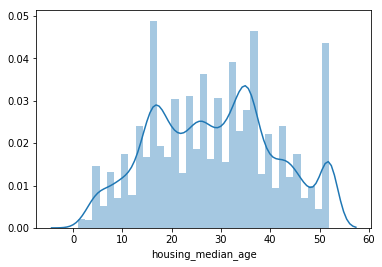

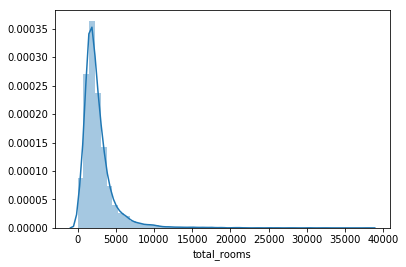

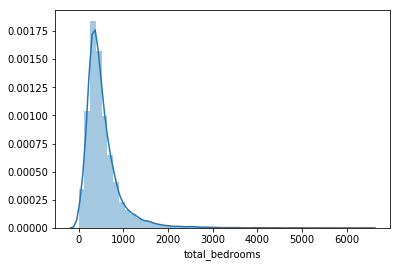

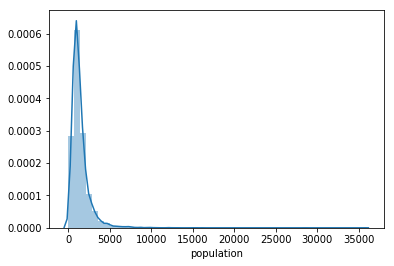

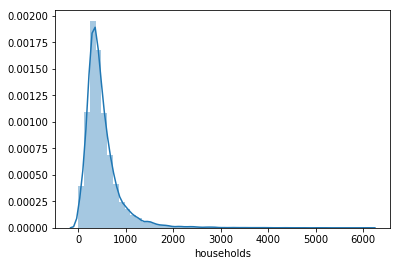

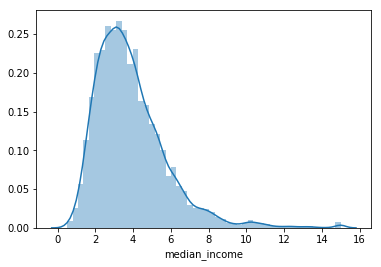

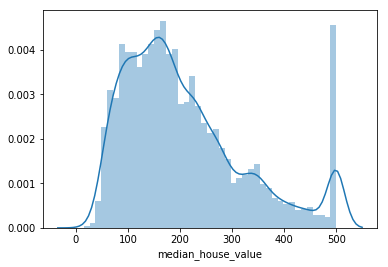

In [8]:
def plot_distributions(dataset, features):
    for feature in features:
        sns.distplot(dataset[feature])
        plt.show()
plot_distributions(cali_housing_data, list(cali_housing_data.columns))

Latitude/longitude are uninteresting, the set of correlated features seem like they might benefit from outlier clipping. There's also this weird uptick in `median_house_value` binned at ~480-500. I'll explore this later in feature engineering phase

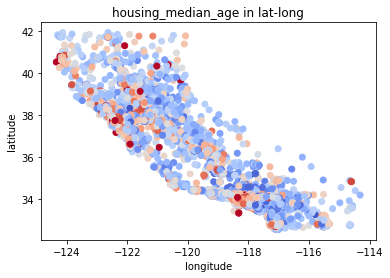

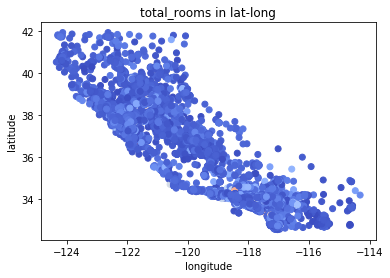

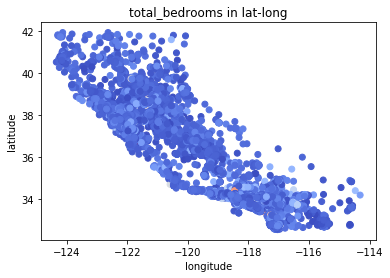

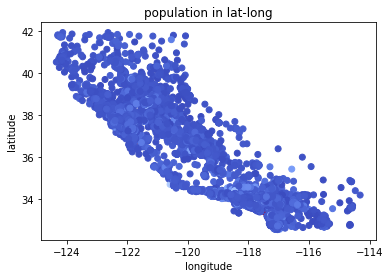

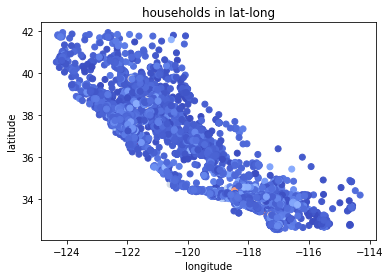

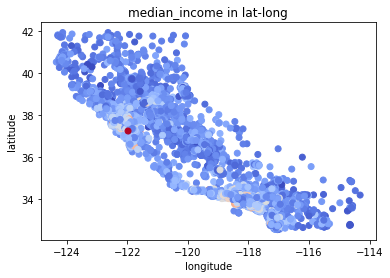

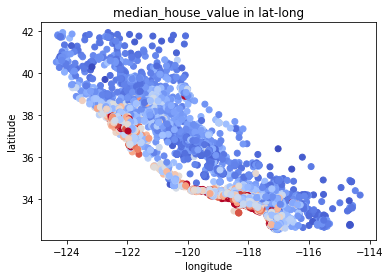

In [9]:
# How does geographical position influence other features?
def scatter_features_coolwarm(dataset, feature_1_name, feature_2_name, feature_3_name, title=""):
    plt.figure()
    plt.title(title)
    plt.xlabel(feature_1_name)
    plt.ylabel(feature_2_name)
    plt.scatter(dataset[feature_1_name], dataset[feature_2_name], cmap="coolwarm", c=dataset[feature_3_name] / dataset[feature_3_name].max())

features_to_coolwarm = [item for item in list(cali_housing_data.columns) if item not in ("longitude", "latitude")]   
    
for feature in features_to_coolwarm:
    scatter_features_coolwarm(cali_housing_data, "longitude", "latitude", feature, feature + " in lat-long")

`population` is greater in LA as expected, `median_income` slightly rises there as well. `median_house_value` is significantly greater near the coast.

## Test-train split, verification of equal distributions
- split (20%) to create the validation dataset
- visualize that the distributions are +- the same

In [10]:
from sklearn.model_selection import train_test_split
target = "median_house_value"
features = [item for item in list(cali_housing_data.columns) if item != target]
X = cali_housing_data[features]
y = cali_housing_data[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13600 entries, 7231 to 6360
Data columns (total 8 columns):
longitude             13600 non-null float64
latitude              13600 non-null float64
housing_median_age    13600 non-null float64
total_rooms           13600 non-null float64
total_bedrooms        13600 non-null float64
population            13600 non-null float64
households            13600 non-null float64
median_income         13600 non-null float64
dtypes: float64(8)
memory usage: 956.2 KB


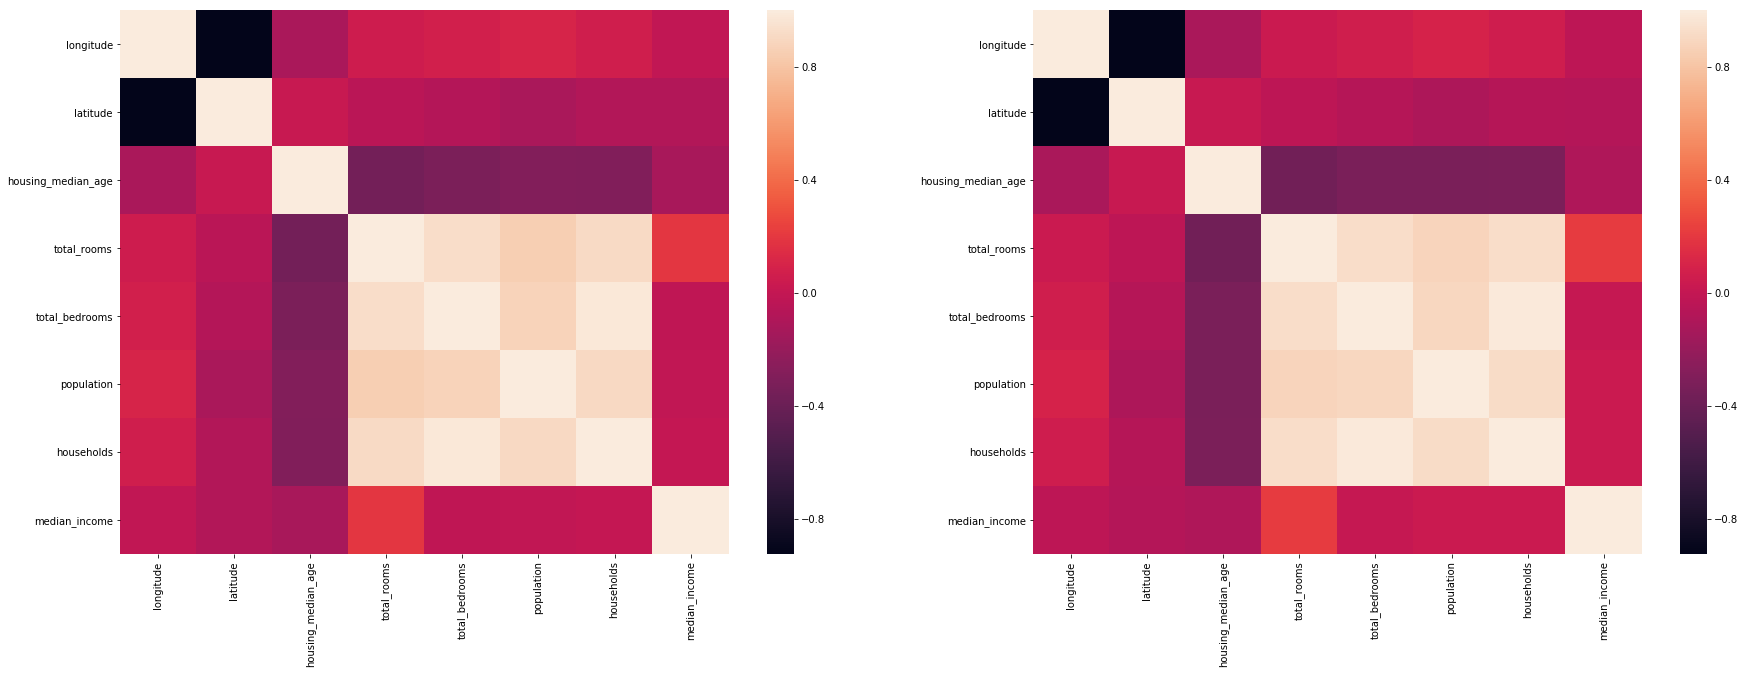

In [11]:
from IPython import display
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(X_train.corr(), ax=ax1)
sns.heatmap(X_valid.corr(), ax=ax2)
plt.show()

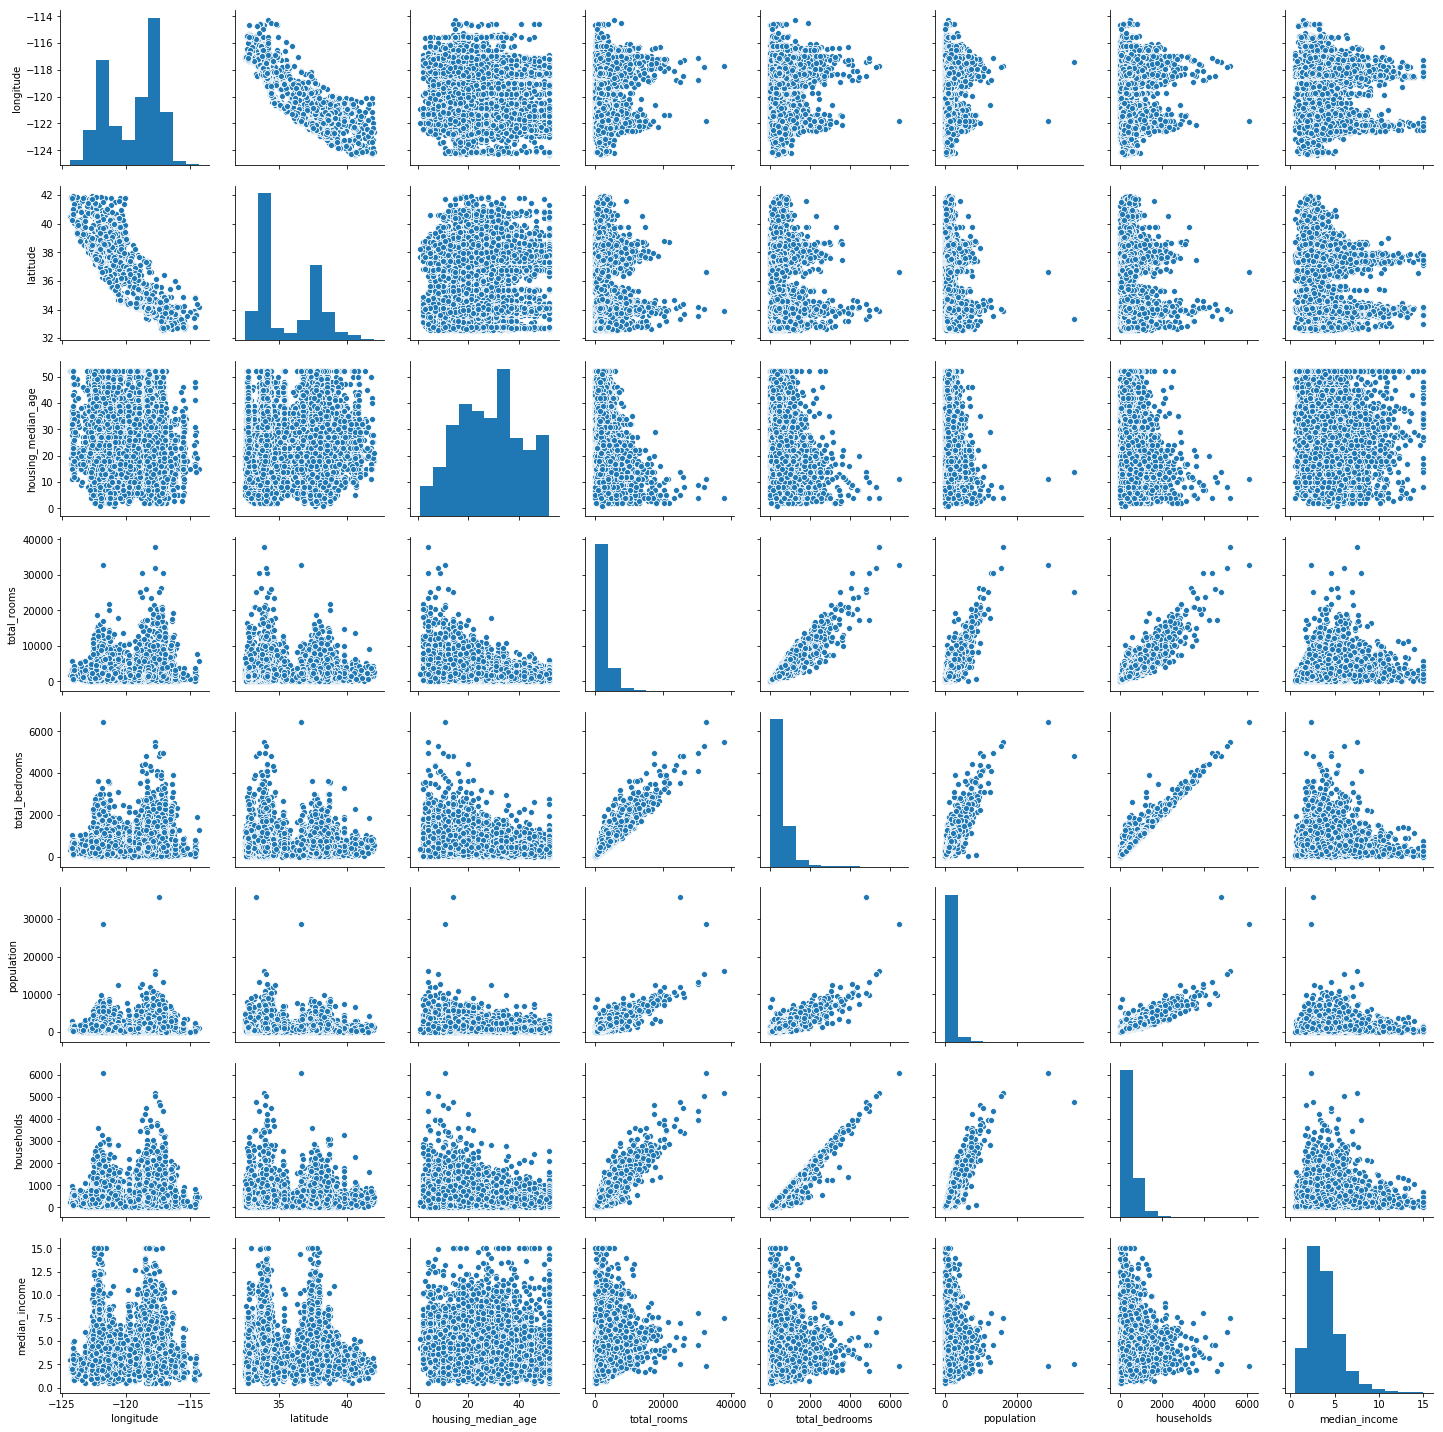

In [12]:
sns.pairplot(X_train)

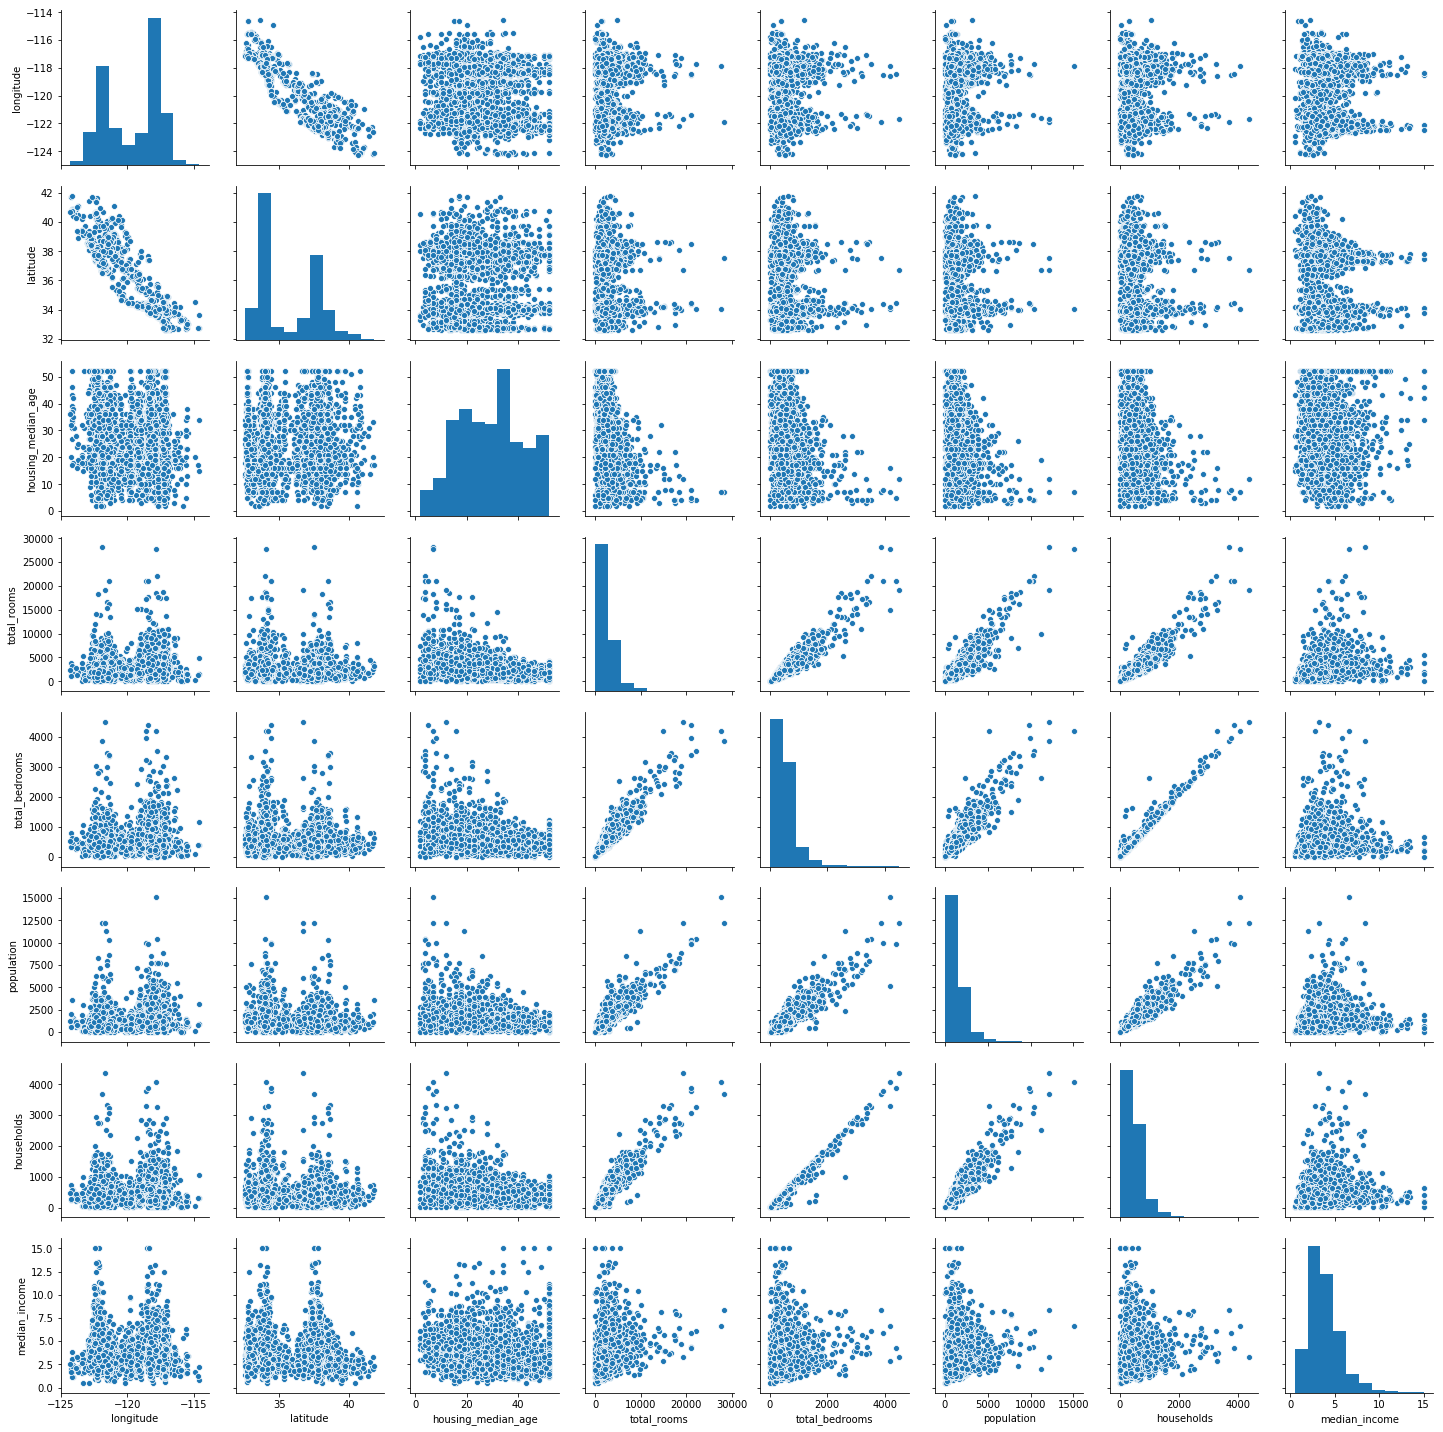

In [13]:
sns.pairplot(X_valid)

The distributions are similar, we can say that the validation dataset is sufficiently representative of the problem and go to creating the baseline model.

## Trying out tf.estimator.LinearRegressor

In [14]:
# 1. define features and targets
feature = cali_housing_data[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
targets = cali_housing_data["median_house_value"]

# 2. Configure the linear regression model
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=optimizer
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [16]:
from data_sci_helpers.tf import input_func
_ = linear_regressor.train(
    input_fn = lambda:input_func(feature, targets),
    steps=100
)

prediction_input_fn = lambda: input_func(feature, targets, num_epochs=1, shuffle=False)

predictions = linear_regressor.predict(input_fn=prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])

A nice property of tensorflow is that you can access the learned weights that are normally abstracted away, so I can actually plot the fitted linear function.

In [17]:
linear_regressor.get_variable_names()

['global_step',
 'linear/linear_model/bias_weights',
 'linear/linear_model/total_rooms/weights']

(0, 10000)

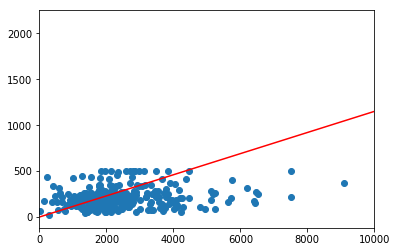

In [18]:
sample = cali_housing_data.sample(n=300)

x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

plt.plot([x_0, x_1], [y_0, y_1], c='r')
plt.xlim(0, 10000)
plt.scatter(sample["total_rooms"], sample["median_house_value"])
plt.show()

In [19]:
print(math.sqrt(metrics.mean_squared_error(predictions, targets)))

279.3412532119441


## Setting up a baseline training loop
### GOAL: Get the baseline results that i'll be improving upon
### Properties:
- run the model with only one feature (every feature) vs. all the features
- LinearRegressor as a model
- RMSE for a loss function
- 10 periods, 500 steps in total, 100 batch size, 0.0005 LR

In [20]:
def train_with_single_feature(X_train, y_train, X_valid, y_valid, lr, steps, batch_size, input_feature, periods):
    # 1. define features and targets
    feature_columns = [tf.feature_column.numeric_column(input_feature)]

    # Create input functions.
    training_input_fn = lambda:input_func(X_train[[input_feature]], y_train, batch_size=batch_size)
    prediction_input_fn = lambda:input_func(X_train[[input_feature]], y_train, num_epochs=1, shuffle=False)
    prediction_validation_input_fn = lambda: input_func(X_valid[[input_feature]], y_valid, num_epochs=1, shuffle=False)
    # 2. Configure the linear regression model
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=optimizer
    )
    sample = cali_housing_data.sample(n=300)
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 2, 1)
    plt.title("Scatter graph of features and predicted line")
    plt.scatter(sample[input_feature], sample["median_house_value"])
    print(f"Training for {periods} periods using {input_feature}")
    root_mean_squared_errors = []
    validation_root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps/periods
        )
        # Compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        rmse = math.sqrt(metrics.mean_squared_error(predictions, y_train))

        validation_predictions = linear_regressor.predict(input_fn=prediction_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        valid_rmse = math.sqrt(metrics.mean_squared_error(validation_predictions, y_valid))
        # Print the loss
        print(f"Period {period} : Training RMSE: {rmse} ; Valid. RMSE: {valid_rmse} ")
        root_mean_squared_errors.append(rmse)
        validation_root_mean_squared_errors.append(valid_rmse)

        weight = linear_regressor.get_variable_value(f'linear/linear_model/{input_feature}/weights')[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        y_0 = weight * sample[input_feature].min() + bias
        y_1 = weight * sample[input_feature].max()+ bias

        plt.plot([sample[input_feature].min(), sample[input_feature].max()], [y_0, y_1], c=colors[period])
        plt.xlim(sample[input_feature].min(), sample[input_feature].max())
        plt.ylim(sample["median_house_value"].min(), sample["median_house_value"].max())

    plt.subplot(2, 2, 2)
    plt.title(f"RMSE vs. Periods ({input_feature})")
    plt.plot(root_mean_squared_errors)

    plt.subplot(2, 2, 3)
    plt.title(f"Validation RMSE vs. Periods ({input_feature})")
    plt.plot(validation_root_mean_squared_errors)
    return validation_root_mean_squared_errors[-1]

### Use all the other features individually to predict `median_house_value`
- Set up whole loop together with train-validation split, since we don't want to overtrain on validation data


Training for 10 periods using longitude
Period 0 : Training RMSE: 187.464794954394 ; Valid. RMSE: 188.26898126684168 
Period 1 : Training RMSE: 145.25657598614694 ; Valid. RMSE: 145.81363384619695 
Period 2 : Training RMSE: 119.18331771514471 ; Valid. RMSE: 119.30335835108795 
Period 3 : Training RMSE: 115.92258491276093 ; Valid. RMSE: 115.76853889222915 
Period 4 : Training RMSE: 115.96720913377082 ; Valid. RMSE: 115.86818493972144 
Period 5 : Training RMSE: 115.92258411680622 ; Valid. RMSE: 115.76853858754308 
Period 6 : Training RMSE: 115.92258469797541 ; Valid. RMSE: 115.76853894971127 
Period 7 : Training RMSE: 115.96720893602854 ; Valid. RMSE: 115.86818478684732 
Period 8 : Training RMSE: 115.96720900436193 ; Valid. RMSE: 115.86818475398188 
Period 9 : Training RMSE: 115.92258535408928 ; Valid. RMSE: 115.7685390396054 
Training for 10 periods using latitude
Period 0 : Training RMSE: 222.11541545644977 ; Valid. RMSE: 222.7492160013345 
Period 1 : Training RMSE: 207.21701281958676 

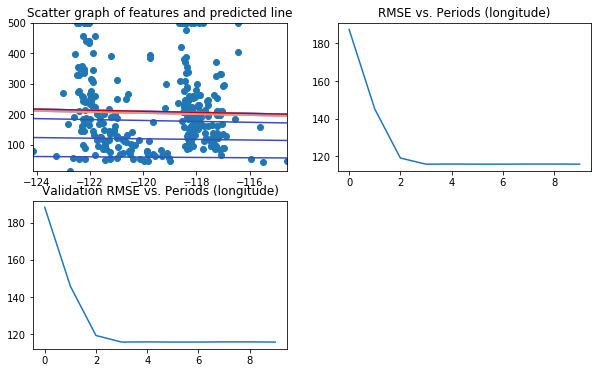

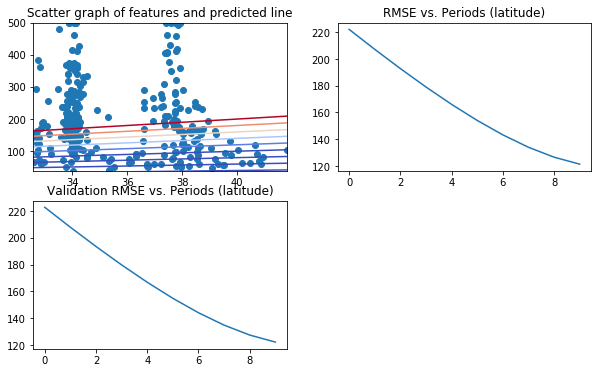

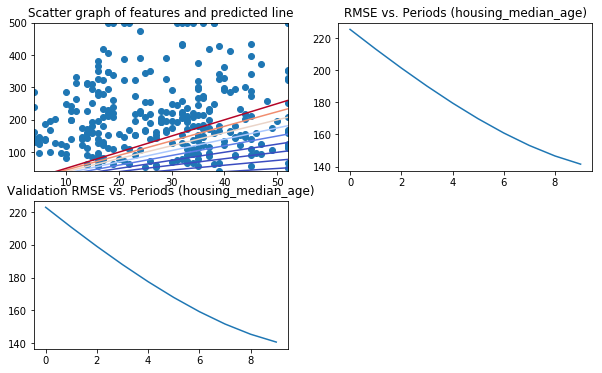

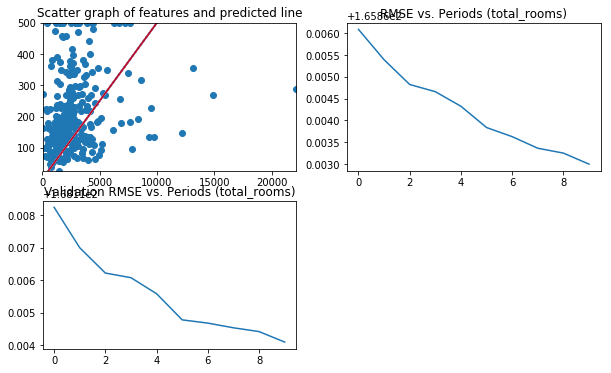

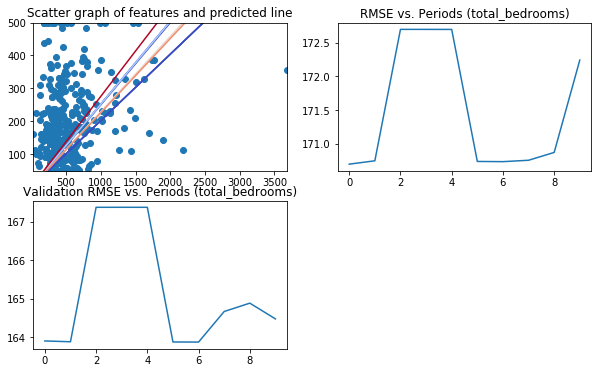

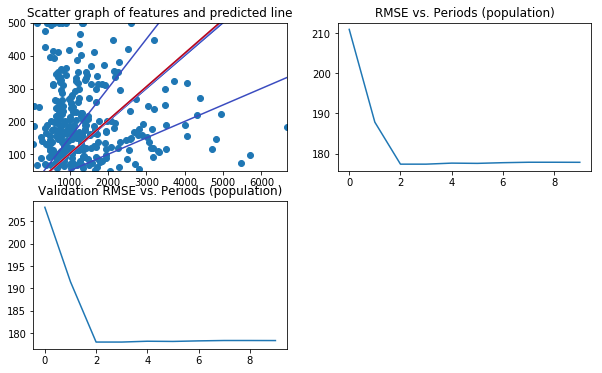

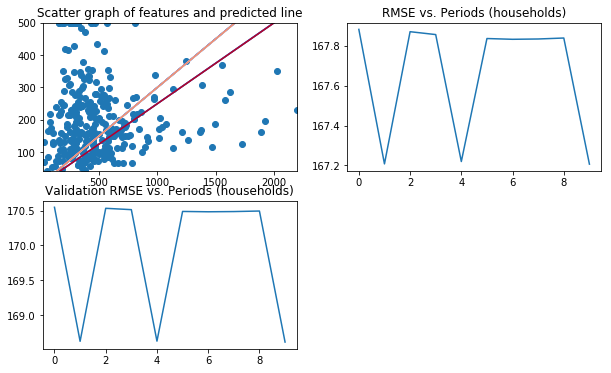

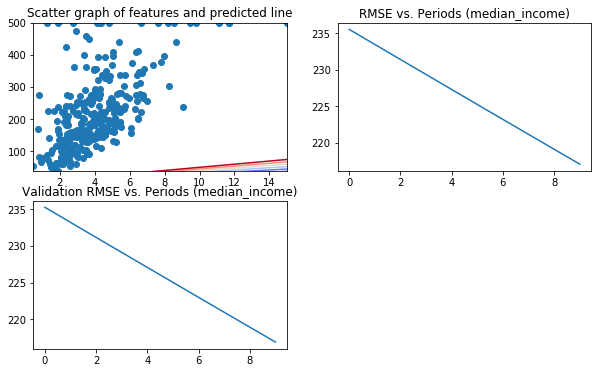

In [21]:
from sklearn.model_selection import train_test_split
from data_sci_helpers.tf import input_func
target = "median_house_value"
features = [item for item in list(cali_housing_data.columns) if item not in (target)]

features_losses = {}
for feature in features:
    X = cali_housing_data[features]
    y = cali_housing_data[target]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    features_losses[feature] = train_with_single_feature(X_train, y_train, X_valid, y_valid, 0.005, 200, 100, feature, 10)

In [22]:
features_losses

{'longitude': 115.7685390396054,
 'latitude': 122.31950327524561,
 'housing_median_age': 140.56357598843113,
 'total_rooms': 168.11409910612036,
 'total_bedrooms': 164.48145605064335,
 'population': 178.30835602281044,
 'households': 168.61581109526685,
 'median_income': 216.8679109670644}

The results are quite interesting. `longitude` and `latitude` are giving the best results. It's possible that for some features the set learning rate was quite high and so they got stuck in local minimum. I'll explore different settings of LR later.

The best baseline performance i could get is around 167.4 on RMSE on a validation dataset, after 7th period the loss didn't improve much. On the scatter-fitting the line plot we can see gradual improvement of the predicted line. Let's see if we can do more with feature engineering!

### Use all the all the features

In [23]:
def numeric_feature_columns(features, dataset):
    numeric = []
    for feature in features:
        numeric.append(tf.feature_column.numeric_column(feature))
    return set(numeric)

X = cali_housing_data[features]
y = cali_housing_data[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

feature_columns = numeric_feature_columns(features, X_train)

Slight modification to the original `train` function, feature columns are constructed separetely

In [24]:
def train(X_train, y_train, X_valid, y_valid, feature_columns, lr, steps, batch_size, periods):
    # Create input functions.
    training_input_fn = lambda:input_func(X_train, y_train, batch_size=batch_size)
    prediction_input_fn = lambda:input_func(X_train, y_train, num_epochs=1, shuffle=False)
    prediction_validation_input_fn = lambda: input_func(X_valid, y_valid, num_epochs=1, shuffle=False)
    # 2. Configure the linear regression model
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=optimizer
    )
    root_mean_squared_errors = []
    validation_root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps/periods
        )
        # Compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        rmse = math.sqrt(metrics.mean_squared_error(predictions, y_train))

        validation_predictions = linear_regressor.predict(input_fn=prediction_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        valid_rmse = math.sqrt(metrics.mean_squared_error(validation_predictions, y_valid))
        # Print the loss
        print(f"Period {period} : Training RMSE: {rmse} ; Valid. RMSE: {valid_rmse} ")
        root_mean_squared_errors.append(rmse)
        validation_root_mean_squared_errors.append(valid_rmse)

    plt.subplot(1, 2, 1)
    plt.title(f"RMSE vs. Periods")
    plt.plot(root_mean_squared_errors)

    plt.subplot(1, 2, 2)
    plt.title(f"Validation RMSE vs. Periods")
    plt.plot(validation_root_mean_squared_errors)
    return linear_regressor

Period 0 : Training RMSE: 194.33465705333091 ; Valid. RMSE: 194.54913291808006 
Period 1 : Training RMSE: 168.2681694149748 ; Valid. RMSE: 174.1058635010535 
Period 2 : Training RMSE: 165.05017601557566 ; Valid. RMSE: 176.5943014124135 
Period 3 : Training RMSE: 165.09999242682113 ; Valid. RMSE: 177.15909518180513 
Period 4 : Training RMSE: 164.34275635138843 ; Valid. RMSE: 172.93213917836368 
Period 5 : Training RMSE: 164.3883036411683 ; Valid. RMSE: 176.13697807952175 
Period 6 : Training RMSE: 164.45057076153793 ; Valid. RMSE: 176.42335435024225 
Period 7 : Training RMSE: 163.84701565650246 ; Valid. RMSE: 172.34662980222174 
Period 8 : Training RMSE: 163.25107598465766 ; Valid. RMSE: 172.98009103498484 
Period 9 : Training RMSE: 163.48305659826693 ; Valid. RMSE: 172.07608101369465 
Period 10 : Training RMSE: 163.56082934047868 ; Valid. RMSE: 171.5880091092891 
Period 11 : Training RMSE: 162.68234392196692 ; Valid. RMSE: 172.18131470620622 
Period 12 : Training RMSE: 164.547598986635

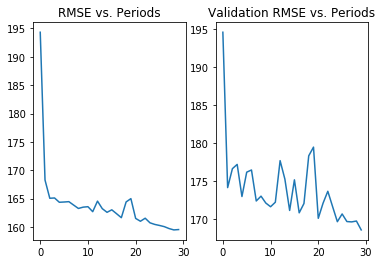

In [25]:
train(X_train, y_train, X_valid, y_valid, feature_columns, 0.0005, 200, 100, 30)

Interestingly enough, some individual features give lower loss than all the features considered together. The loss is somewhat lowering each epoch, but the curve is not smooth by any means and validation loss is a mess. For a baseline though, let's go with this and try to improve with some feature engineering / hyperparameter optimization in Part II.